# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [4]:
# import libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import monotonically_increasing_id
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType,DoubleType
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.mllib.tree import GradientBoostedTrees
from pyspark.ml.feature import OneHotEncoder, MinMaxScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
# from pyspark.ml import Pipeline
from pyspark.ml import Pipeline, PipelineModel

import matplotlib.pyplot as plt
import datetime

In [5]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify project") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

First look at data

In [6]:
path = "mini_sparkify_event_data.json"
data = spark.read.json(path)

In [7]:
# num observarions
data.count()

286500

In [8]:
# cols and datatypes
data.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [9]:
# first row
data.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [10]:
# describe the data
for col in data.schema.names:
    data.describe(col).show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+

+-------+----------+
|summary|      auth|
+-------+----------+
|  count|    286500|
|   mean|      null|
| stddev|      null|
|    min| Cancelled|
|    max|Logged Out|
+-------+----------+

+-------+---------+
|summary|firstName|
+-------+---------+
|  count|   278154|
|   mean|     null|
| stddev|     null|
|    min| Adelaida|
|    max|   Zyonna|
+-------+---------+

+-------+------+
|summary|gender|
+-------+------+
|  count|278154|
|   mean|  null|
| stddev|  null|
|    min|     F|
|    max|     M|
+-------+------+

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            286500|
|   mean|114.41421291448516|
| stddev|129.76726201141085|
|    min|                 0|
|    max| 

### Data cleaning 
1. Remove user_ids equal to empty string `""`

In [11]:
print(data.count())
data.select("userId").dropDuplicates().sort("userId").show()
data_valid = data.filter(data["userId"] != "")
data_valid.count()

286500
+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



278154

 2\. Looking into duplicate rows

In [12]:
print('Rows after dropping duplicates', data_valid.dropDuplicates().count())
print('Rows before dropping duplicates', data_valid.count())

Rows after dropping duplicates 278154
Rows before dropping duplicates 278154


This looks good, no duplicates. Lets double check that the combination of timestamps and userID's also dont have duplicates. 

In [13]:
data_valid.select(['ts', 'userId']).count() - data_valid.dropDuplicates(['ts', 'userId']).count()

745

So it seems there may actually be some duplicates here. Lets look a little closer

In [14]:
data_valid.createOrReplaceTempView('data')

duplicates_statement = """
    SELECT
        userID, ts, COUNT(*)
    FROM
        data
    GROUP BY
        userID, ts
    HAVING 
        COUNT(*) > 1
    LIMIT
        5"""

spark.sql(duplicates_statement).collect()

[Row(userID='124', ts=1540842260000, count(1)=2),
 Row(userID='33', ts=1542409461000, count(1)=2),
 Row(userID='152', ts=1543206099000, count(1)=2),
 Row(userID='36', ts=1539070836000, count(1)=2),
 Row(userID='9', ts=1539714540000, count(1)=2)]

In [15]:
# lets look a little closer at the first of these
data_valid.createOrReplaceTempView('data')

duplicates_statement = """
    SELECT
        *
    FROM
        data
    WHERE
        userID = '124' 
    AND 
        ts = 1540842260000
"""

spark.sql(duplicates_statement).collect()

[Row(artist='Kings Of Convenience', auth='Logged In', firstName='Nicole', gender='F', itemInSession=46, lastName='Beck', length=247.50975, level='paid', location='Vineland-Bridgeton, NJ', method='PUT', page='NextSong', registration=1532224335000, sessionId=1394, song='The Weight Of My Words', status=200, ts=1540842260000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='124'),
 Row(artist=None, auth='Logged In', firstName='Nicole', gender='F', itemInSession=47, lastName='Beck', length=None, level='paid', location='Vineland-Bridgeton, NJ', method='GET', page='Home', registration=1532224335000, sessionId=1394, song=None, status=200, ts=1540842260000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='124')]

It looks like this user seems to have two unique actions at the same time. This isn't necessarily a problem. In this case, the user seems to have changed song and gone to the home page at the same time. Since most streaming applications automatically change songs when they finish it is possible that this could happen at the exact same time that the user takes an action. Therefore I will not drop these rows. 

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

Lets explore the features in more detail

In [16]:
# add a unique id column
df = data_valid.sort(['userID', 'ts', 'sessionId']).withColumn("id", monotonically_increasing_id())
df.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string, id: string]

In [17]:
df.head()

Row(artist='Sea Wolf', auth='Logged In', firstName='Brycen', gender='M', itemInSession=0, lastName='Bradley', length=265.53424, level='paid', location='Laurel, MS', method='PUT', page='NextSong', registration=1538159495000, sessionId=9, song='Ses Monuments', status=200, ts=1538965220000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='10', id=0)

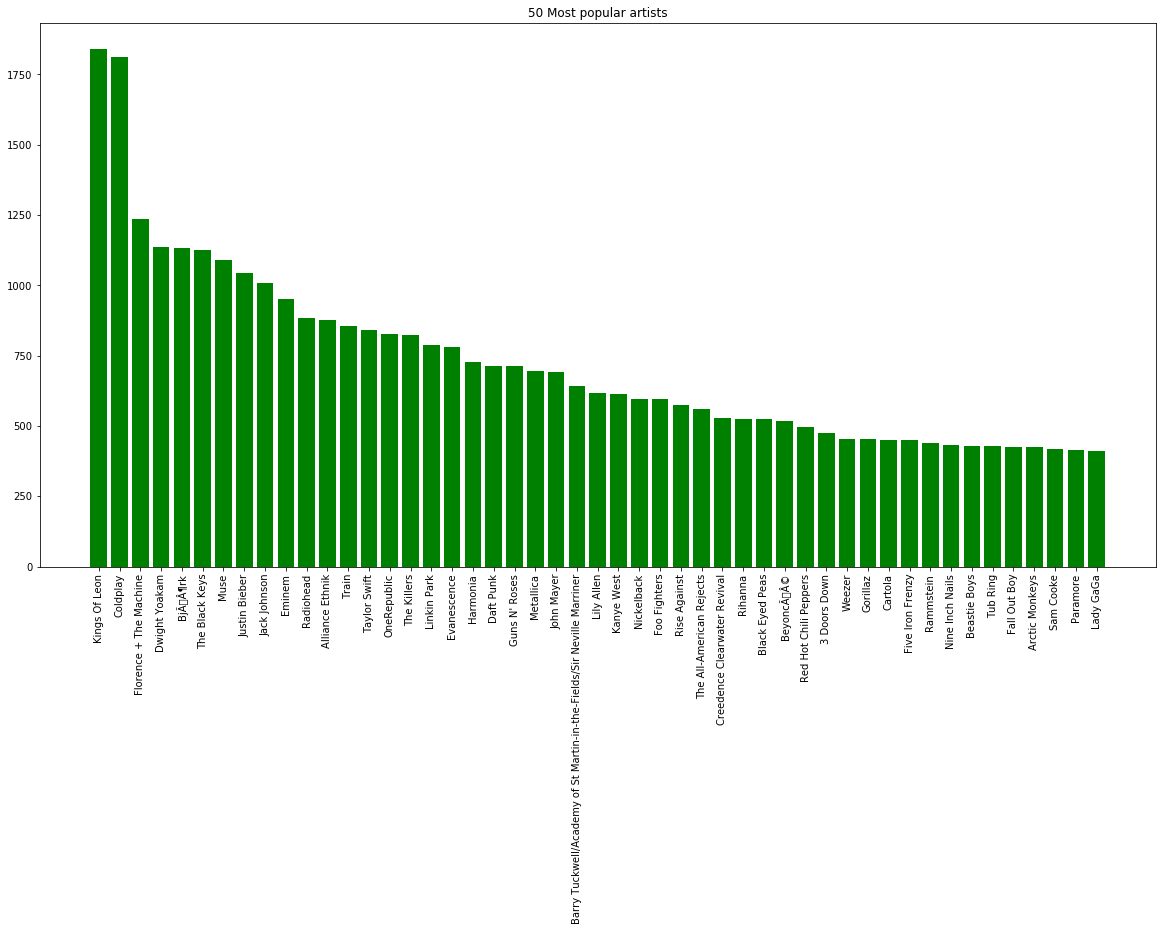

In [18]:
# lets look at the distribution of the 50 most popular artists
df.createOrReplaceTempView('data')
statement = """
    SELECT 
        COUNT(id), artist 
    FROM 
        data
    GROUP BY 
        artist
    ORDER BY 
        COUNT(id) DESC"""
artist_counts = spark.sql(statement).collect()
artist_counts = artist_counts[1:50] # drop None values
artists = [i[1] for i in artist_counts]
counts = [i[0] for i in artist_counts]

# plot
plt.figure(figsize=(20,10))
artists_pos = [i for i, _ in enumerate(artists)]
plt.title('50 Most popular artists')
plt.bar(artists_pos, counts, color='green')
plt.xticks(artists_pos, artists, rotation=90)
plt.show()

In [19]:
# auth takes just two values
df.select('auth').dropDuplicates().sort('auth').show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [20]:
# slightly more female than male activty
df.createOrReplaceTempView('data')
statement = """
    SELECT 
        COUNT(id), gender 
    FROM 
        data
    GROUP BY 
        gender"""
gender_split = spark.sql(statement).collect()
gender_split

[Row(count(id)=154578, gender='F'), Row(count(id)=123576, gender='M')]

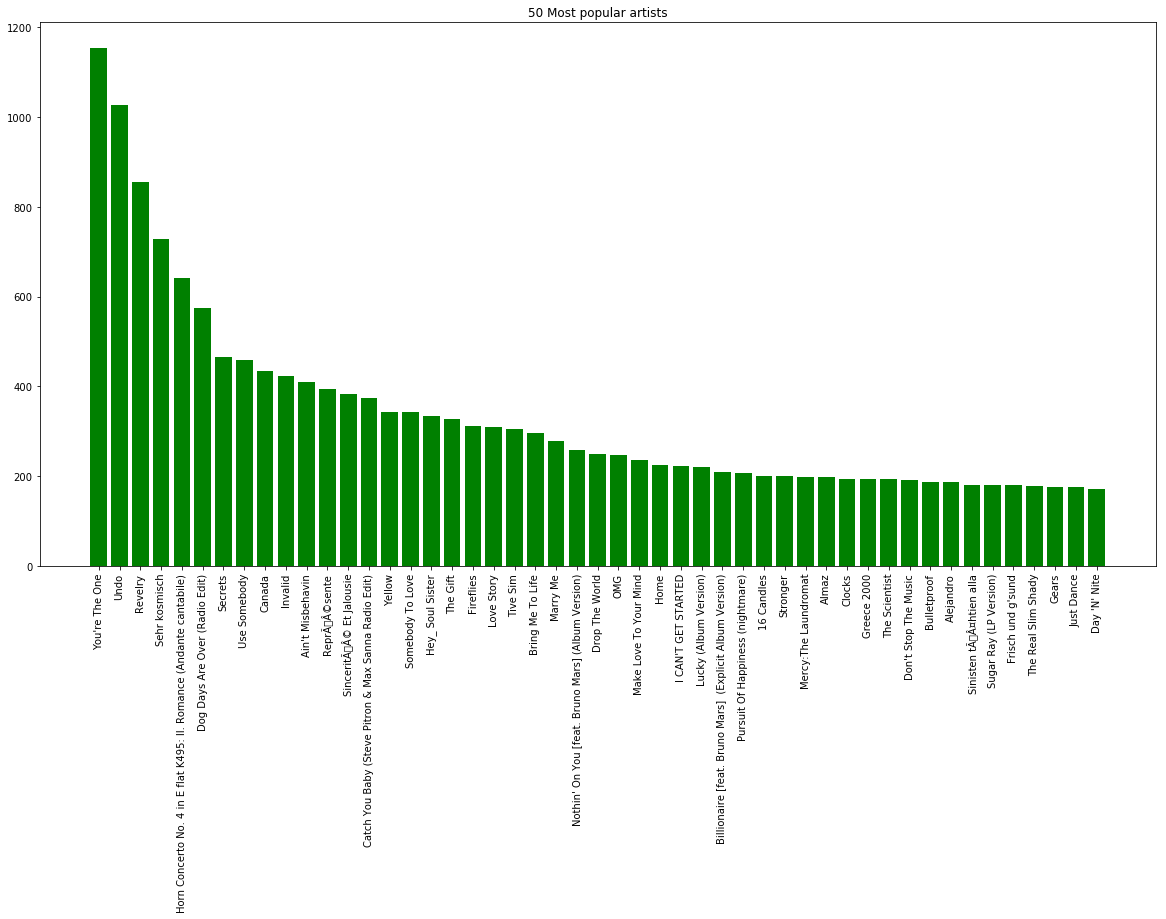

In [21]:
# lets look at the distribution of the 50 most popular songs
df.createOrReplaceTempView('data')
statement = """
    SELECT 
        COUNT(id), song 
    FROM 
        data
    GROUP BY 
        song
    ORDER BY 
        COUNT(id) DESC"""
song_counts = spark.sql(statement).collect()
song_counts = song_counts[1:50] # drop None values
songs = [i[1] for i in song_counts]
counts = [i[0] for i in song_counts]

# plot
plt.figure(figsize=(20,10))
songs_pos = [i for i, _ in enumerate(songs)]
plt.title('50 Most popular artists')
plt.bar(songs_pos, counts, color='green')
plt.xticks(songs_pos, songs, rotation=90)
plt.show()

In [22]:
# the feature page can take the following values
df.select('page').dropDuplicates().sort('page').show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.


As suggested we will define churn as users who recieve a `Cancellation Confirmation`

In [23]:
churned_user_list = (df.filter(df.page == 'Cancellation Confirmation')
                       .select('userId')
                       .distinct()
                       .rdd.flatMap(lambda x: x)
                       .collect())

df = df.withColumn('churn', F.when(df.userId.isin(churned_user_list), 1).otherwise(0))

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [24]:
df.createOrReplaceTempView('data')
statement = """
    SELECT 
        userID, count(churn), sum(churn)
    FROM 
        data
    GROUP BY 
        userID"""
users = spark.sql(statement).collect()

Ratio of users who churn:  0.2311111111111111


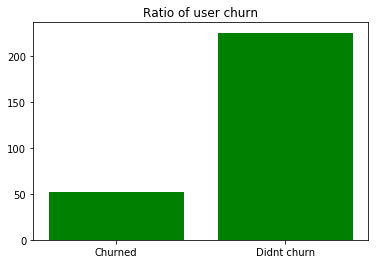

In [25]:
# number of users who churned
user_churn = [1 if user[2]>0 else 0 for user in users]

print('Ratio of users who churn: ', sum(user_churn)/len(user_churn))

plt.bar([0,1], [sum(user_churn), len(user_churn)], color='green')
plt.xticks([0,1], ['Churned', 'Didnt churn'])
plt.title('Ratio of user churn')
plt.show()

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [26]:
# number of songs played
song_count = (df.where(df.song!='null')
                .groupby('userId')
                .agg({'song':'count'})
                .orderBy('userId')
                .withColumnRenamed("count(song)", "song_count")
             )
        
song_count.show()

+------+----------+
|userId|song_count|
+------+----------+
|    10|       673|
|   100|      2682|
|100001|       133|
|100002|       195|
|100003|        51|
|100004|       942|
|100005|       154|
|100006|        26|
|100007|       423|
|100008|       772|
|100009|       518|
|100010|       275|
|100011|        11|
|100012|       476|
|100013|      1131|
|100014|       257|
|100015|       800|
|100016|       530|
|100017|        52|
|100018|      1002|
+------+----------+
only showing top 20 rows



In [27]:
# use gender as a feature
counts = df.groupBy(['userId', 'gender']).count().alias('counts')
gender = (counts
          .groupBy('userId')
          .agg(F.max(F.struct(F.col('count'),
                              F.col('gender'))).alias('max'))
          .select(F.col('userId'), F.col('max.gender'))
          .orderBy('userId')
         )

gender = (gender
          .withColumn('gender', 
                      F.when(
                          F.col('gender') == 'M', 1)
                      .when(
                          F.col('gender') == 'F',0)
                     )
         )

gender.show()

+------+------+
|userId|gender|
+------+------+
|    10|     1|
|   100|     1|
|100001|     0|
|100002|     0|
|100003|     0|
|100004|     0|
|100005|     1|
|100006|     0|
|100007|     0|
|100008|     0|
|100009|     1|
|100010|     0|
|100011|     1|
|100012|     1|
|100013|     0|
|100014|     1|
|100015|     0|
|100016|     1|
|100017|     1|
|100018|     1|
+------+------+
only showing top 20 rows



In [28]:
# use days active as a feature
min_ts = df.select(["userId", "ts"]).groupby("userId").min("ts")
max_ts = df.select(["userId", "ts"]).groupby("userId").max("ts")
convert_time = 86400000
days_active = min_ts.join(max_ts, on="userId")
days_active = (days_active.withColumn("days_active", (F.col("max(ts)")-F.col("min(ts)")) / convert_time))
days_active = days_active.select(["userId", "days_active"]).orderBy('userId')

In [59]:
# number of friends added
add_friend_count = (df.where(df.page=='Add Friend')
                .groupby('userId')
                .agg({'page':'count'})
                .orderBy('userId')
                .withColumnRenamed("count(page)", "add_friend_count")
             )
        
add_friend_count.show()

+------+----------------+
|userId|add_friend_count|
+------+----------------+
|    10|              12|
|   100|              49|
|100001|               2|
|100002|               1|
|100004|              19|
|100005|               3|
|100006|               4|
|100007|              17|
|100008|              17|
|100009|               7|
|100010|               4|
|100012|               2|
|100013|              28|
|100014|               6|
|100015|              14|
|100016|              13|
|100018|              23|
|100019|               2|
|100021|               7|
|100022|              11|
+------+----------------+
only showing top 20 rows



In [29]:
# get the labels (where 1 = churned)
label = (df
         .groupby('userId')
         .agg({'churn':'first'})
         .orderBy('userId') 
         .withColumnRenamed('first(churn)', 'label')
        )
        
label.show()

+------+-----+
|userId|label|
+------+-----+
|    10|    0|
|   100|    0|
|100001|    1|
|100002|    0|
|100003|    1|
|100004|    0|
|100005|    1|
|100006|    1|
|100007|    1|
|100008|    0|
|100009|    1|
|100010|    0|
|100011|    1|
|100012|    1|
|100013|    1|
|100014|    1|
|100015|    1|
|100016|    0|
|100017|    1|
|100018|    0|
+------+-----+
only showing top 20 rows



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [62]:
# create modelling df
modelling_data = song_count.join(gender, 'userId', 'full').join(days_active, 'userId', 'full').join(add_friend_count, 'userId', 'full').join(label, 'userId', 'full').drop('userId')
modelling_data = modelling_data.fillna({'add_friend_count':0}) 

In [64]:
# train test split
train, test = modelling_data.randomSplit([0.8, 0.2])

Train a Logistic regression model

In [65]:
# Create vector from feature data
feature_names = train.drop('label').schema.names
vec_asembler = VectorAssembler(inputCols = feature_names, outputCol = 'Features')

# scales columns between 0 and 1
scalar = MinMaxScaler(inputCol='Features', outputCol='ScaledFeatures')

lr = LogisticRegression(featuresCol='ScaledFeatures', labelCol='label')
dt = DecisionTreeClassifier(featuresCol='ScaledFeatures', labelCol='label')
rf = RandomForestClassifier(featuresCol='ScaledFeatures', labelCol='label')

pipeline_lr = Pipeline(stages=[vec_asembler, scalar, lr])
pipeline_dt = Pipeline(stages=[vec_asembler, scalar, dt])
pipeline_rf = Pipeline(stages=[vec_asembler, scalar, rf])

# evaluator = BinaryClassificationEvaluator()
evaluator = MulticlassClassificationEvaluator(metricName="f1")

In [66]:
# create param grids
lr_paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam,[0.0, 0.1]) 
             .build()
            )
dt_paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth,[1, 2]) 
             .build()
            )
rf_paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees,[5, 10, 20])
             .addGrid(rf.subsamplingRate, [0.5, 0.75, 1])
             .build()
            )

num_folds = 2

# create cross validation pipelines
lr_crossval = CrossValidator(estimator=pipeline_lr,
                      estimatorParamMaps=lr_paramGrid,
                      evaluator=evaluator,
                      numFolds=num_folds)
dt_crossval = CrossValidator(estimator=pipeline_dt,
                      estimatorParamMaps=dt_paramGrid,
                      evaluator=evaluator,
                      numFolds=num_folds)
rf_crossval = CrossValidator(estimator=pipeline_rf,
                      estimatorParamMaps=rf_paramGrid,
                      evaluator=evaluator,
                      numFolds=num_folds)


In [67]:
# train models
trained_lr = lr_crossval.fit(train)
trained_dt = dt_crossval.fit(train)
trained_rf = rf_crossval.fit(train)


In [70]:
# asses model performance
results = trained_lr.transform(test)
score = evaluator.evaluate(results)
print(f'F1 score for logistic regression is {score}')

results = trained_dt.transform(test)
score = evaluator.evaluate(results)
print(f'F1 score for decision tree is {score}')

results = trained_rf.transform(test)
score = evaluator.evaluate(results)
print(f'F1 score for random forest is {score}')


F1 score for logistic regression is 0.7373511904761906
F1 score for decision tree is 0.5640509725016768
F1 score for random forest is 0.8116059379217274
